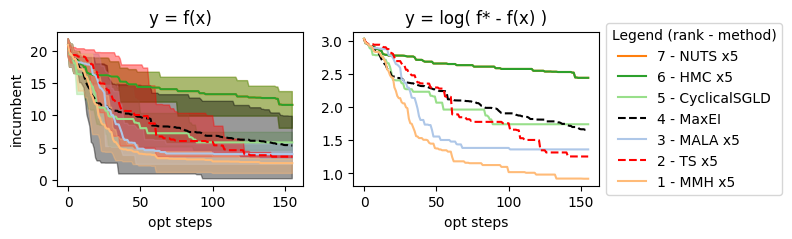

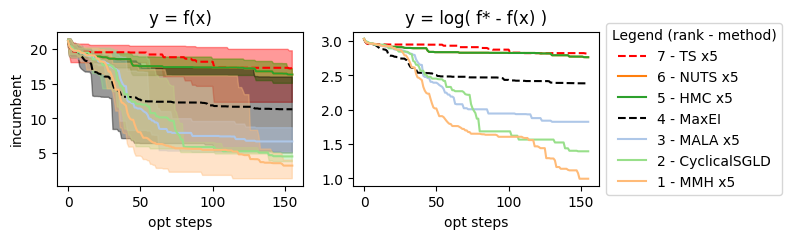

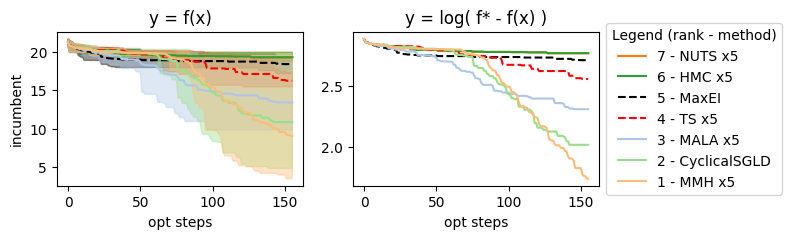

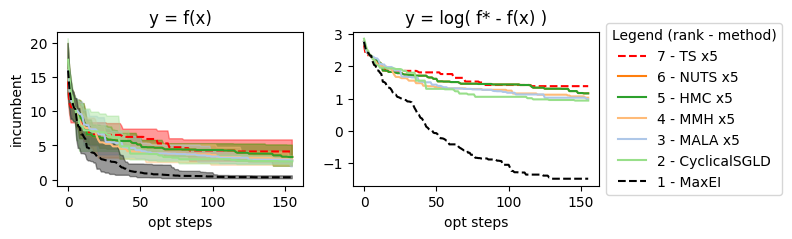

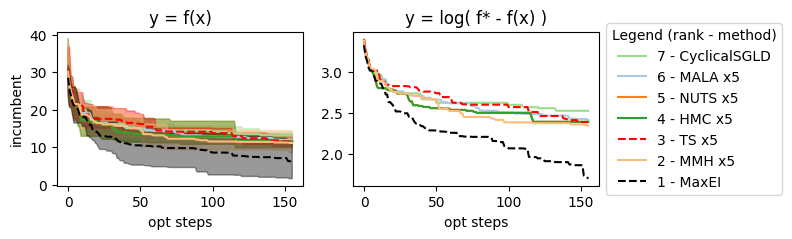

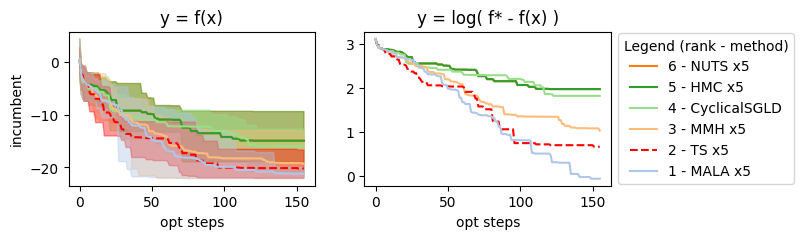

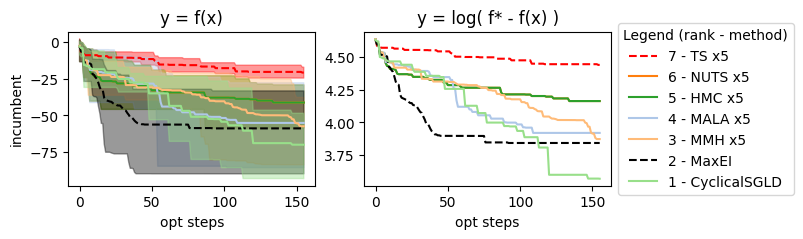

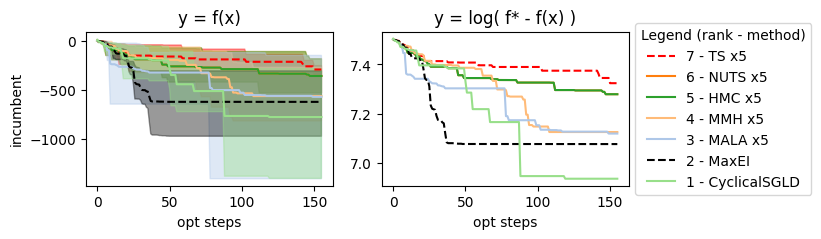

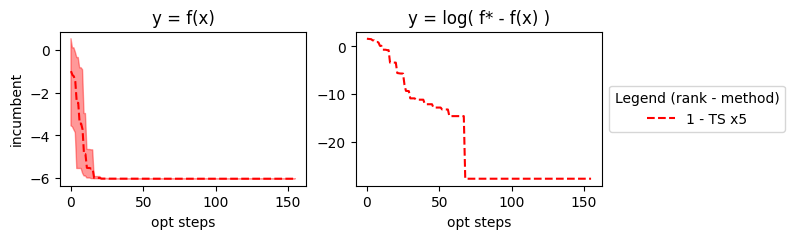

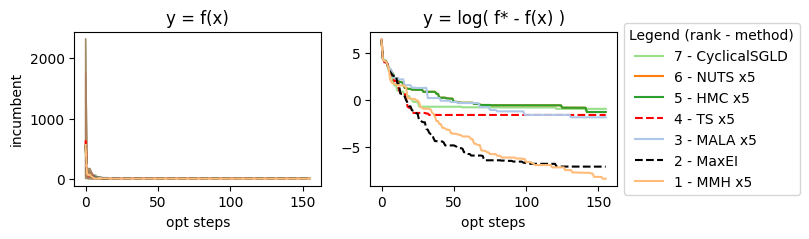

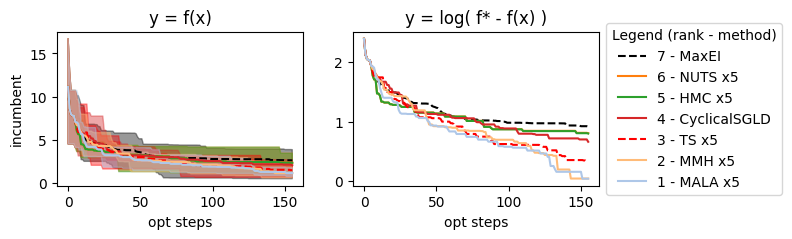

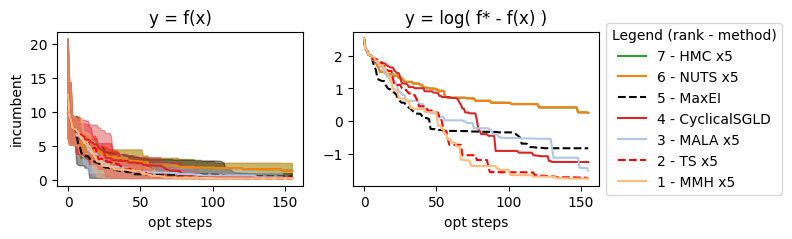

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pickle

import os
import sys
import re
sys.path.append('../') # Make main module visible

from bbs.experiment_runner import ExperimentResults
from bbs.experiment_runner import stacked_results, plot_optimization

def load_result(filename):
    with open(filename, 'rb') as fp:
        data = pickle.load(fp)
    return ExperimentResults(**data)

def func_and(*funcs):
    def _call(*args, **kwargs):
        for f in funcs:
            if not f(*args, **kwargs):
                return False
        return True
    return _call

def func_or(*funcs):
    def _call(*args, **kwargs):
        for f in funcs:
            if f(*args, **kwargs):
                return True
        return False
    return _call

def is_in_folder(folder):
    if isinstance(folder, tuple):
        folder = folder[0]
    subdirs = os.listdir(folder)
    def _call(p,m):
        return p in subdirs
    return _call

any_in = lambda arr, text: any(s in text for s in arr)
all_in = lambda arr, text: all(s in text for s in arr)
plot_all = lambda p, m: True

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def plot_results(list_folder, plot_only_fn=plot_all, folder_prefix=None, **kwargs):
    if all(isinstance(f,tuple) for f in list_folder):
        if folder_prefix is None:
            folder_prefix = [f[1] for f in list_folder]
        list_folder = [f[0] for f in list_folder]

    problem_set = set()
    for res_folder in list_folder:
        problem_set |= set(os.listdir(res_folder))

    for problem in sorted(problem_set, key=natural_keys):
        plot_folder(list_folder, problem, plot_only_fn, folder_prefix=folder_prefix, **kwargs)
        plt.show()


#list_color = ['k','r','g','b', 'y']
list_color = matplotlib.colormaps['tab20'].colors
def plot_folder(list_folder, problem, plot_only_fn, folder_prefix=None, style_overwrite_fn=lambda x, _: x, verbose=1, save=False, **kwargs):
    if folder_prefix is not None:
        assert(len(list_folder) == len(folder_prefix))

    list_exp_res = []
    list_exp_name = []
    list_exp_label = []

    for i_folder, folder in enumerate(list_folder):
        path_folder_problem = os.path.join(folder,problem)

        if not os.path.isdir(path_folder_problem):
            if verbose > 1: print(f'{problem} not found in folder {folder}, skipping.')
            continue

        for subfolder in os.listdir(path_folder_problem):
            path_folder_problem_method = os.path.join(path_folder_problem, subfolder)

            problem_name = problem
            method_name = subfolder.strip('/').split('/')[-1]

            if method_name in list_exp_name and folder_prefix is None:
                if verbose > 0: print(f'Warning: {path_folder_problem_method} ignored due to already. Please define folder_prefix.')
                continue

            all_res = []
            for filename in os.listdir(path_folder_problem_method):
                filepath = os.path.join(path_folder_problem_method,filename)
                if filename.endswith('.pkl'):
                    all_res.append(load_result(filepath))
                if filename.startswith('error_log'):
                    if verbose > 0: print(f'Warning: missing experiment, only found {filepath}')

            if plot_only_fn(problem_name, method_name) and len(all_res) > 0:
                list_exp_res.append(stacked_results(all_res))
                list_exp_name.append(method_name)

                label_name = method_name
                if folder_prefix is not None: 
                    label_name = folder_prefix[i_folder] + label_name
                label_name = str(len(all_res)) + '@' + label_name

                list_exp_label.append(label_name)
        
    if len(list_exp_res) > 0:
        ax_size = (3.5,2)
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(2*ax_size[0],1*ax_size[1]))
        #f.suptitle(problem)
        list_plot_options = [
            style_overwrite_fn({
                'label': list_exp_label[i], 
                'color': list_color[i%len(list_color)]
            }, e_name) 
        for i,e_name in enumerate(list_exp_name)]

        plot_optimization(ax1, list_exp_res, experiments_plot_options=list_plot_options, plot_log_min=False, **kwargs)
        ax1.set_title('y = f(x)')
        plot_optimization(ax2, list_exp_res, experiments_plot_options=list_plot_options, plot_log_min=True, **kwargs|{'plot_confidence': False})
        ax2.set_title('y = log( f* - f(x) )')

        #[ax.legend(prop={'size': 6}) for ax in [ax2]]

        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Legend (rank - method)")
        
        ax2.set_ylabel('')
        #ax2.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.2f}"))

        if save:
            f.savefig(problem + '.pdf', bbox_inches='tight')
    else:
        if verbose > 1: print(f'Info: Folder {folder} has no results according to current filter.')


def plot_only_log_ei(prob, method):
    return method.endswith('log_ei')


any_thompson = lambda p,m: 'sample_thompson' in m
any_max_ei = lambda p,m: 'max_' in m
any_boltzmann = lambda p,m: 'sample_boltzmann' in m
default_ignored_methods = lambda p,m: not('sample_boltzmann' in m and any_in(['MALA', 'HMC'], m))


def get_default_style_overwrite(label_translator):
    def _func(style, m):
        new_style = {}
        if 'max_' in m:
            new_style['color'] = 'k'
        if 'sample_thompson' in m:
            new_style['color'] = 'r'
        if '_log_ei' in m:
            new_style['linestyle'] = '--'
        if 'paramclip' in m:
            new_style['marker'] = 'x'

        for k,v in label_translate.items():
            if k in m:
                new_style['label'] = v
                break 
        return style | new_style
    return _func

res_main_methods = ('../results_main_methods/', 'MAIN/')
res_mcmc_battery = ('../results_mcmc_battery_1st_try/', 'MCMC_OLD/')
res_mcmc_new = ('../results_mcmc_battery_2nd/', 'MCMC/')
res_5query = ('../results_5queries_experiments/', '5QUE/')
res_5thompson = ('../results_5queries_thompson/', 'TS/')
res_current = ('../results/', 'NEWEST/')


# res_current = res_current
# plot_results([res_main_methods, res_current, res_5thompson], sort_labels=True, plot_confidence=True,
#     style_overwrite_fn=default_style_overwrite_fn,
#     plot_only_fn=func_and(
#         is_in_folder(res_current), 
# #        default_ignored_methods,
# #         func_or(any_thompson, any_max_ei, 
# #            lambda p,m: 'sample_boltzmann' in m and 'x2000' in m
# #         ),
#     )
# )

def PLOT_CLEANUP():
    def get_cleanup_style_overwrite(label_translator):
        def _func(style, m):
            new_style = {}
            if 'max_' in m:
                new_style['color'] = 'k'
            if 'sample_thompson' in m:
                new_style['color'] = 'r'
            if '_log_ei' in m and not 'max_' in m:
                new_style['linestyle'] = '-'
            else:
                new_style['linestyle'] = '--'
            if 'temperature' in m:
                new_style['marker'] = '*'
            
            if not 'temperature' in m:
                for k,v in label_translator.items():
                    if k in m:
                        new_style['label'] = v
                        break 
            return style | new_style
        return _func

    res_boltzmann = ('../cleanup_results/results_5queries_boltzmann/', '')
    res_thompson = ('../cleanup_results/results_5queries_thompson/', '')
    res_ei = ('../cleanup_results/results_max_log_ei_full/', '')

    label_translate = {
        'max_log_ei': 'MaxEI',
        'max_ei': 'EI',

        'thompson_-_queries_5_-_x4000': 'TS x5',
        #'thompson_-_queries_5_-_x2000': 'TS x5 (2k)',

        '_sampler_CyclicalSGLD_paramclip': 'CyclicalSGLD',
        '_sampler_NUTSx5_paramclip': 'NUTS x5',
        '_sampler_HMCx5_paramclip': 'HMC x5',
        '_sampler_MALAx5_paramclip': 'MALA x5',
        '_sampler_MultiproposalMHx5_': 'MMH x5',
        #'_sampler_MultiproposalMH_': 'Multiproposal MH',
    }

    plot_results([res_thompson, res_boltzmann, res_ei, res_current], sort_labels=True, plot_confidence=True,
        style_overwrite_fn=get_cleanup_style_overwrite(label_translate),
        plot_only_fn=func_and(
            #is_in_folder(res_boltzmann), 
            lambda p,m: not 'thompson_-_queries_5_-_x2000' in m,
            lambda p,m: not 'sampler_CyclicalSGLD_default_x4000' in m,
            lambda p,m: not 'max_ei' in m,
            lambda p,m: not '_sampler_MultiproposalMH_' in m,
        ),
        save=True,
        use_quantiles=0.9,
    )
PLOT_CLEANUP()

{'label': '10@sample_temperature_boltzmann_-_temp_0.01_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)} sample_temperature_boltzmann_-_temp_0.01_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_temperature_boltzmann_-_temp_1.0_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)} sample_temperature_boltzmann_-_temp_1.0_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_temperature_boltzmann_-_temp_0.1_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (1.0, 0.4980392156862745, 0.054901960784313725)} sample_temperature_boltzmann_-_temp_0.1_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_boltzmann_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (1.0, 0.7333333333333333, 0.47058823529411764)}

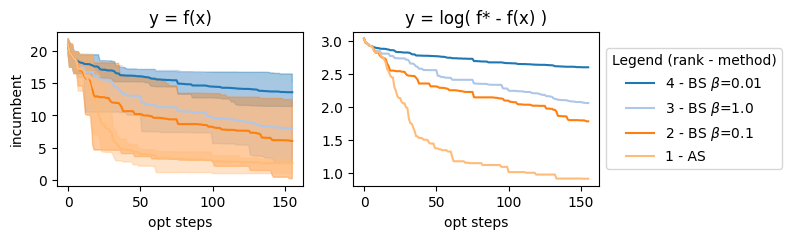

{'label': '10@sample_temperature_boltzmann_-_temp_0.01_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)} sample_temperature_boltzmann_-_temp_0.01_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_temperature_boltzmann_-_temp_1.0_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)} sample_temperature_boltzmann_-_temp_1.0_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_temperature_boltzmann_-_temp_0.1_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (1.0, 0.4980392156862745, 0.054901960784313725)} sample_temperature_boltzmann_-_temp_0.1_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_boltzmann_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (1.0, 0.7333333333333333, 0.47058823529411764)}

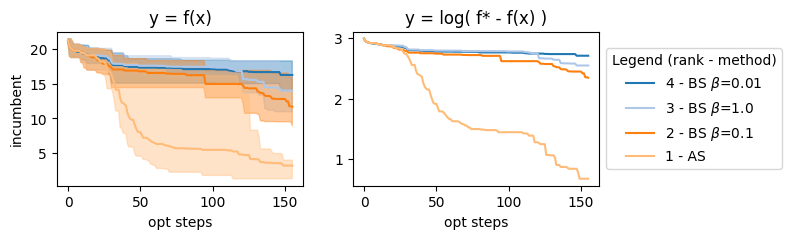

{'label': '10@sample_temperature_boltzmann_-_temp_0.01_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)} sample_temperature_boltzmann_-_temp_0.01_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_temperature_boltzmann_-_temp_1.0_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)} sample_temperature_boltzmann_-_temp_1.0_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_temperature_boltzmann_-_temp_0.1_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (1.0, 0.4980392156862745, 0.054901960784313725)} sample_temperature_boltzmann_-_temp_0.1_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000
{'label': '10@sample_boltzmann_-_queries_5_-_crit_log_ei_-_sampler_MultiproposalMHx5_x4000', 'color': (1.0, 0.7333333333333333, 0.47058823529411764)}

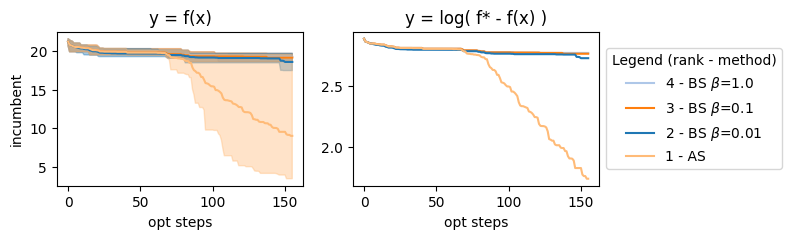

In [ ]:

def PLOT_CLEANUP2():
    def get_cleanup_style_overwrite(label_translator):
        def _func(style, m):
            print(style, m)
            new_style = {}
            if 'max_' in m:
                new_style['color'] = 'k'
            if 'sample_thompson' in m:
                new_style['color'] = 'r'
            if '_log_ei' in m and not 'max_' in m:
                new_style['linestyle'] = '-'
            else:
                new_style['linestyle'] = '--'
            

            for k,v in label_translator.items():
                if k in m:
                    new_style['label'] = v
                    break 
            return style | new_style
        return _func

    res_boltzmann = ('../cleanup_results/results_5queries_boltzmann/', '')
    res_temperature = ('../cleanup_results/results_temperature/', '')

    label_translate = {
        '_-_temp_1.0_-_': r'BS $\beta$=1.0',
        '_-_temp_0.1_-_': r'BS $\beta$=0.1',
        '_-_temp_0.01_-_': r'BS $\beta$=0.01',
        '_sampler_MultiproposalMHx5_': 'AS',
    }

    plot_results([res_temperature, res_boltzmann, res_current], sort_labels=True, plot_confidence=True,
        style_overwrite_fn=get_cleanup_style_overwrite(label_translate),
        plot_only_fn=func_and(
            is_in_folder(res_temperature), 
            func_or(
                lambda p,m: 'sample_temperature' in m,
                lambda p,m: '_sampler_MultiproposalMHx5_' in m,
            )
        ),
        save=True,
        use_quantiles=0.9,
    )
PLOT_CLEANUP2()

In [4]:
import jax.numpy as jnp

def bounds_resizer(bounds, resize):
    pivot = bounds.mean(axis=1)
    print('pivot', pivot)
    centered_bounds = bounds - pivot
    print('\t centered_bounds', centered_bounds)
    centered_rescaled_bounds = centered_bounds * resize
    print('\t centered_rescaled_bounds', centered_rescaled_bounds)
    return centered_rescaled_bounds + pivot




bounds = jnp.array([[0.,1.] for _ in range(3)])
bounds = jnp.array([[0., 1.], [1., 2.]])

pivot = bounds.mean(axis=1)
print(jnp.repeat(pivot, 2).reshape(-1,2))
print('orig_bounds', bounds)
#print('resize x1.1', bounds_resizer(bounds, 1.1))

[[0.5 0.5]
 [1.5 1.5]]
orig_bounds [[0. 1.]
 [1. 2.]]
